In [1]:
import sys
from pathlib import Path

# Add project root to sys.path
project_root = Path().resolve().parent
sys.path.append(str(project_root))

In [2]:
import pandas as pd

from src.preprocessing import preprocess_data
from src.config import RAW_DATA_PATH

df = preprocess_data(RAW_DATA_PATH)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group,service_count
0,7590-VHVEG,Female,No,Yes,No,1,0,0,1,0,...,0,0,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-12 Months,2
1,5575-GNVDE,Male,No,No,No,34,1,0,1,1,...,0,0,One year,No,Mailed check,56.95,1889.50,No,12-36 Months,4
2,3668-QPYBK,Male,No,No,No,2,1,0,1,1,...,0,0,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-12 Months,4
3,7795-CFOCW,Male,No,No,No,45,0,0,1,1,...,0,0,One year,No,Bank transfer (automatic),42.30,1840.75,No,36-60 Months,4
4,9237-HQITU,Female,No,No,No,2,1,0,1,0,...,0,0,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0-12 Months,2


In [3]:
# Selecting features for modeling
features = ["tenure", "MonthlyCharges", "TotalCharges", "service_count"]
X = df[features]

In [4]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

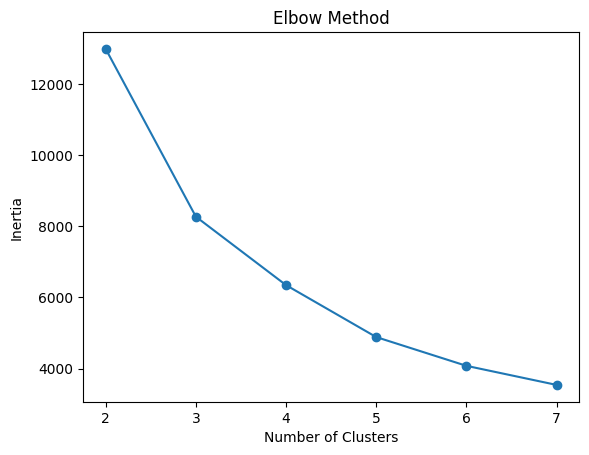

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 8), inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [6]:
inertia

[12979.321189161092,
 8267.712629768148,
 6345.586391697241,
 4887.147342328282,
 4079.5428607953995,
 3543.496559879854]

In [7]:
kmeans = KMeans(n_clusters=4, random_state=42)
df["segment"] = kmeans.fit_predict(X_scaled)

In [8]:
df.groupby("segment")[["tenure", "MonthlyCharges", "TotalCharges", "service_count"]].mean()

,tenure,MonthlyCharges,TotalCharges,service_count
segment,,,,
0,54.038306,30.101210,1615.461442,2.089718
1,59.327820,92.030125,5449.386441,6.733835
2,17.220506,78.877349,1336.666731,4.582154
3,9.208116,34.082899,270.339043,1.747246


In [9]:
pd.crosstab(df["segment"], df["Churn"])

Churn,No,Yes
segment,,
0,948,44
1,1696,299
2,1303,1028
3,1227,498


In [10]:
# Absolute counts
count_table = pd.crosstab(df["segment"], df["Churn"])

# Row-wise percentage
percent_table = pd.crosstab(df["segment"], df["Churn"], normalize="index") * 100

count_table.columns = ["No_Count", "Yes_Count"]
percent_table.columns = ["No_%", "Yes_%"]

combined_table = pd.concat([count_table, percent_table], axis=1)
combined_table

,No_Count,Yes_Count,No_%,Yes_%
segment,,,,
0,948,44,95.564516,4.435484
1,1696,299,85.012531,14.987469
2,1303,1028,55.898756,44.101244
3,1227,498,71.130435,28.869565


In [11]:
df['segment'].value_counts().sort_index()

segment
0     992
1    1995
2    2331
3    1725
Name: count, dtype: int64

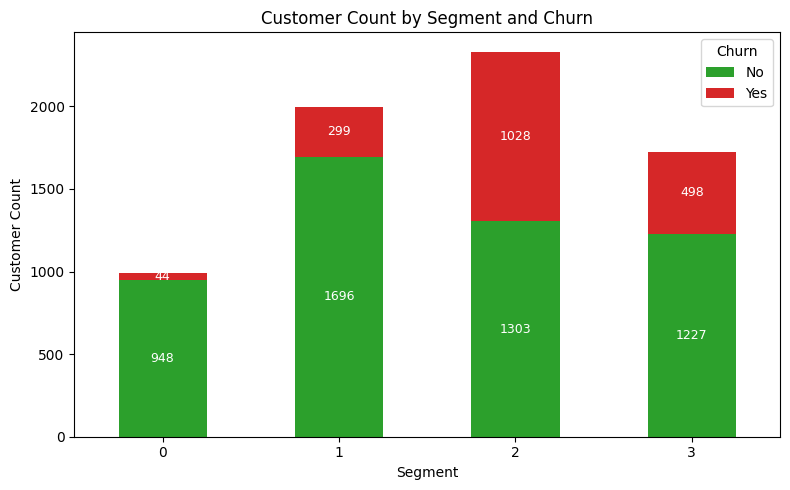

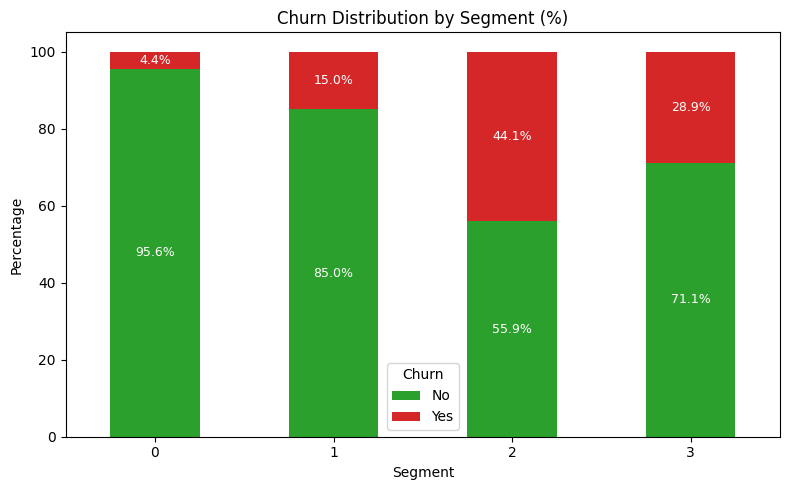

In [12]:
# Visualize segment distribution by Churn status

# Ensure consistent figure size
fig, ax = plt.subplots(figsize=(8, 5))

# Stacked bar: segments split by Churn (Yes/No)
ax = count_table.sort_index().plot(
    kind="bar",
    stacked=True,
    color=["#2ca02c", "#d62728"],
    ax=ax
)
ax.set_xlabel("Segment")
ax.set_ylabel("Customer Count")
ax.set_title("Customer Count by Segment and Churn")
ax.legend(["No", "Yes"], title="Churn")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Annotate counts on bars
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(
            int(p.get_height()),
            (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height() / 2),
            ha="center",
            va="center",
            color="white",
            fontsize=9
        )

plt.tight_layout()
plt.show()

#-------------------------------------------------------------------------------------------

# Stacked bar: segments split by Churn (Yes/No) - Percentage

# Ensure consistent figure size
fig, ax = plt.subplots(figsize=(8, 5))

percent_table.sort_index().plot(
    kind="bar",
    stacked=True,
    color=["#2ca02c", "#d62728"],
    ax=ax
)

ax.set_xlabel("Segment")
ax.set_ylabel("Percentage")
ax.set_title("Churn Distribution by Segment (%)")
ax.legend(["No", "Yes"], title="Churn")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Annotate percentages
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(
            f"{p.get_height():.1f}%",
            (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height() / 2),
            ha="center",
            va="center",
            color="white",
            fontsize=9
        )

plt.tight_layout()
plt.show()


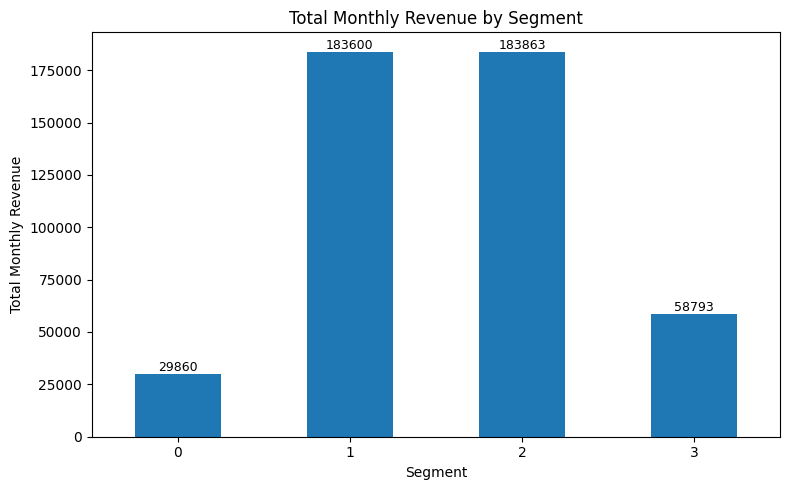

In [13]:
# Compute total monthly revenue per segment
revenue_by_segment = df.groupby("segment")["MonthlyCharges"].sum()

fig, ax = plt.subplots(figsize=(8, 5))

revenue_by_segment.sort_index().plot(
    kind="bar",
    color="#1f77b4",
    ax=ax
)

ax.set_xlabel("Segment")
ax.set_ylabel("Total Monthly Revenue")
ax.set_title("Total Monthly Revenue by Segment")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Annotate values
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()

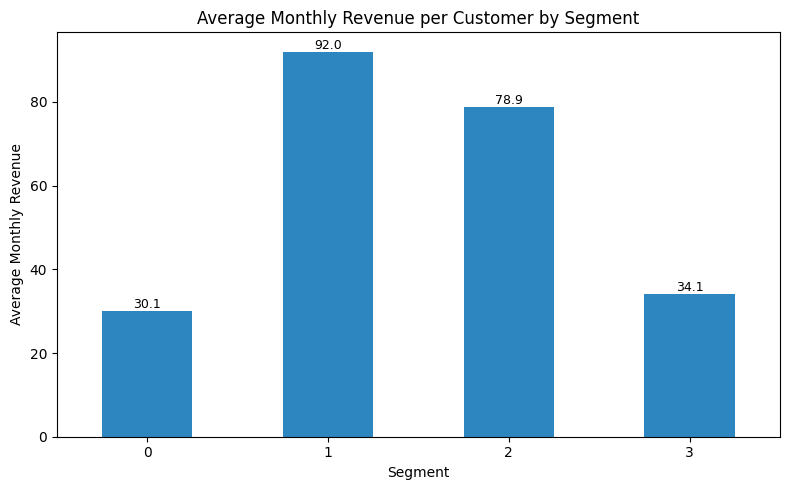

In [14]:
avg_monthly_revenue = df.groupby("segment")["MonthlyCharges"].mean()

fig, ax = plt.subplots(figsize=(8, 5))

avg_monthly_revenue.sort_index().plot(
    kind="bar",
    color="#2E86C1",
    ax=ax
)

ax.set_xlabel("Segment")
ax.set_ylabel("Average Monthly Revenue")
ax.set_title("Average Monthly Revenue per Customer by Segment")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Annotate values
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()

<b>Segment-Based Churn Insights</b>
<ul><li>
<b>Segment 2 (High-Value At Risk)</b> shows the highest churn rate (~44%), despite relatively high monthly charges and moderate service adoption. This represents the most critical retention segment.
</li><li>
<b>Segment 3 (New & Low Engagement)</b> has moderate churn (~29%), driven by low tenure and low service adoption. Early lifecycle intervention is important for this group.
</li><li>
<b>Segment 1 (Premium Loyal)</b> generates high revenue with relatively low churn (~15%), making it a valuable but stable segment requiring proactive loyalty engagement.
</li><li>
<b>Segment 0 (Stable Low-Value Loyal)</b> exhibits extremely low churn (~4%), indicating strong long-term retention despite lower revenue contribution.
</li></ul>

The most dangerous segment is not the newest or lowest-value group, but the mid-tenure, high-spend segment (Segment 2), which combines meaningful revenue with high churn probability.
